# package import

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

plt.rc('font', family='AppleGothic')

# 데이터 불러오기

In [11]:
dataPath = '../../data/'
df = pd.read_csv(f'{dataPath}/processed/no_NaN_dataset_final.csv', encoding='utf-8')

In [12]:
data = df

In [13]:
df = df.drop('총인구수-학령인구(명)', axis=1)

In [14]:
df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),행정구역
0,서울특별시,종로구,2010,170578,17,14,1107,852,1011,396,29164,서울특별시 종로구
1,서울특별시,중구,2010,132822,13,12,1170,671,1049,378,19628,서울특별시 중구
2,서울특별시,용산구,2010,244853,19,15,2312,1086,1784,528,37318,서울특별시 용산구
3,서울특별시,성동구,2010,309093,31,20,2886,1226,2306,672,51562,서울특별시 성동구
4,서울특별시,광진구,2010,375463,42,22,3366,1290,2672,811,67422,서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...
2894,경상남도,함양군,2022,37708,12,13,76,668,90,60,4135,경상남도 함양군
2895,경상남도,거창군,2022,60387,16,17,175,804,163,94,8548,경상남도 거창군
2896,경상남도,합천군,2022,42142,15,17,97,899,89,71,3385,경상남도 합천군
2897,제주특별자치도,제주시,2022,493389,74,69,2766,3281,2034,1102,84346,제주특별자치도 제주시


# 사용 feature 아리마 모델로 향후 10년치 예측

In [15]:
def forecasting_features(data, steps=10):

    sido = data['행정구역(시도)'].unique().tolist()[0]
    sigungu = data['행정구역(시군구)'].unique().tolist()[0]
    sido_sigungu = sido + ' ' + sigungu
    year = data['연도'].unique().tolist()[-1]

    future_data = {'행정구역(시도)': np.array([sido for i in range(steps)]),
               '행정구역(시군구)': np.array([sigungu for i in range(steps)]),
               '행정구역': np.array([sido_sigungu for i in range(steps)]),
               '연도': np.array([i for i in range(year + 1, year + steps + 1)])}

    for col in data.columns:
        if col in ('행정구역(시도)', '행정구역(시군구)', '행정구역', '연도'):
            continue
        else:
            value = data[col]
            time_series = value.values
            future_feature = []
            for step in range(1, steps + 1):
                # ARIMA 모델 생성 및 훈련
                order = (1, 2, 1)  # (p, d, q)
                model = ARIMA(time_series, order=order)
                results = model.fit()

                # 예측
                forecast_steps = 1
                forecast = results.get_forecast(steps=forecast_steps)

                # 예측 결과
                forecast_mean = forecast.predicted_mean.round()

                # 업데이트된 데이터
                future_feature.append(forecast_mean)

                # 업데이트된 시계열 데이터
                time_series = np.append(time_series, forecast_mean)

            future_data[col] = np.array(future_feature).flatten()

    return future_data

In [16]:
from tqdm import tqdm

for region in tqdm(df['행정구역'].unique().tolist()):
    temp_df = df[df['행정구역'] == region]

    future_data = forecasting_features(temp_df)
    future_df = pd.DataFrame(future_data)

    df = pd.concat([df, future_df])

  0%|          | 0/223 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/dataScience/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
  0%|          | 1/223 [00:02<08:58,  2.43s/it]/opt/homebrew/Caskroom/miniforge/base/envs/dataScience/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/dataScience/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/dataScience/lib/python3.11/site-packages/statsmodels/base/model.py:6

In [17]:
df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),행정구역
0,서울특별시,종로구,2010,170578.0,17.0,14.0,1107.0,852.0,1011.0,396.0,29164.0,서울특별시 종로구
1,서울특별시,중구,2010,132822.0,13.0,12.0,1170.0,671.0,1049.0,378.0,19628.0,서울특별시 중구
2,서울특별시,용산구,2010,244853.0,19.0,15.0,2312.0,1086.0,1784.0,528.0,37318.0,서울특별시 용산구
3,서울특별시,성동구,2010,309093.0,31.0,20.0,2886.0,1226.0,2306.0,672.0,51562.0,서울특별시 성동구
4,서울특별시,광진구,2010,375463.0,42.0,22.0,3366.0,1290.0,2672.0,811.0,67422.0,서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...
5,제주특별자치도,서귀포시,2028,192316.0,45.0,45.0,550.0,1850.0,536.0,483.0,26449.0,제주특별자치도 서귀포시
6,제주특별자치도,서귀포시,2029,193629.0,45.0,45.0,503.0,1900.0,512.0,474.0,26202.0,제주특별자치도 서귀포시
7,제주특별자치도,서귀포시,2030,194947.0,45.0,45.0,456.0,1950.0,488.0,492.0,25961.0,제주특별자치도 서귀포시
8,제주특별자치도,서귀포시,2031,196268.0,45.0,45.0,409.0,2000.0,464.0,486.0,25726.0,제주특별자치도 서귀포시


In [18]:
df.sort_values(by=['행정구역', '연도'], inplace=True)

In [19]:
df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),행정구역
103,강원특별자치도,강릉시,2010,218503.0,40.0,35.0,1641.0,1413.0,1071.0,487.0,43102.0,강원특별자치도 강릉시
326,강원특별자치도,강릉시,2011,217571.0,40.0,35.0,1671.0,1434.0,1140.0,496.0,41960.0,강원특별자치도 강릉시
549,강원특별자치도,강릉시,2012,217741.0,40.0,35.0,1636.0,1490.0,1107.0,475.0,41589.0,강원특별자치도 강릉시
772,강원특별자치도,강릉시,2013,216806.0,40.0,35.0,1460.0,1471.0,1026.0,528.0,40758.0,강원특별자치도 강릉시
995,강원특별자치도,강릉시,2014,215807.0,41.0,35.0,1298.0,1539.0,983.0,473.0,39345.0,강원특별자치도 강릉시
...,...,...,...,...,...,...,...,...,...,...,...,...
5,충청북도,충주시,2028,199876.0,40.0,29.0,443.0,3965.0,589.0,392.0,22297.0,충청북도 충주시
6,충청북도,충주시,2029,198144.0,40.0,28.0,372.0,4281.0,560.0,385.0,21256.0,충청북도 충주시
7,충청북도,충주시,2030,196907.0,39.0,27.0,301.0,4596.0,531.0,378.0,20215.0,충청북도 충주시
8,충청북도,충주시,2031,195173.0,39.0,26.0,230.0,4911.0,502.0,371.0,19174.0,충청북도 충주시


In [22]:
df.to_csv(f'{dataPath}/processed/forecasting_dataset(2010-2032).csv', encoding='utf-8', index=False)

In [23]:
# 2022년까지의 데이터만 추출
orignal_df = df[df['연도'] <= 2022]

# 2022년 이후의 데이터만 추출
forecasting_df = df[df['연도'] > 2022]

In [24]:
orignal_df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),행정구역
103,강원특별자치도,강릉시,2010,218503.0,40.0,35.0,1641.0,1413.0,1071.0,487.0,43102.0,강원특별자치도 강릉시
326,강원특별자치도,강릉시,2011,217571.0,40.0,35.0,1671.0,1434.0,1140.0,496.0,41960.0,강원특별자치도 강릉시
549,강원특별자치도,강릉시,2012,217741.0,40.0,35.0,1636.0,1490.0,1107.0,475.0,41589.0,강원특별자치도 강릉시
772,강원특별자치도,강릉시,2013,216806.0,40.0,35.0,1460.0,1471.0,1026.0,528.0,40758.0,강원특별자치도 강릉시
995,강원특별자치도,강릉시,2014,215807.0,41.0,35.0,1298.0,1539.0,983.0,473.0,39345.0,강원특별자치도 강릉시
...,...,...,...,...,...,...,...,...,...,...,...,...
1904,충청북도,충주시,2018,210504.0,46.0,38.0,1155.0,1675.0,1003.0,497.0,32850.0,충청북도 충주시
2127,충청북도,충주시,2019,210737.0,44.0,37.0,1100.0,1674.0,870.0,490.0,31724.0,충청북도 충주시
2350,충청북도,충주시,2020,210186.0,44.0,36.0,1042.0,1682.0,811.0,485.0,30569.0,충청북도 충주시
2573,충청북도,충주시,2021,209358.0,44.0,36.0,954.0,1770.0,747.0,436.0,29591.0,충청북도 충주시


In [25]:
forecasting_df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),행정구역
0,강원특별자치도,강릉시,2023,209819.0,37.0,36.0,825.0,2090.0,700.0,402.0,27031.0,강원특별자치도 강릉시
1,강원특별자치도,강릉시,2024,208247.0,37.0,37.0,763.0,2150.0,644.0,393.0,25679.0,강원특별자치도 강릉시
2,강원특별자치도,강릉시,2025,206680.0,37.0,37.0,700.0,2203.0,625.0,387.0,24333.0,강원특별자치도 강릉시
3,강원특별자치도,강릉시,2026,205110.0,37.0,38.0,637.0,2263.0,585.0,379.0,22985.0,강원특별자치도 강릉시
4,강원특별자치도,강릉시,2027,203541.0,37.0,38.0,574.0,2320.0,557.0,372.0,21638.0,강원특별자치도 강릉시
...,...,...,...,...,...,...,...,...,...,...,...,...
5,충청북도,충주시,2028,199876.0,40.0,29.0,443.0,3965.0,589.0,392.0,22297.0,충청북도 충주시
6,충청북도,충주시,2029,198144.0,40.0,28.0,372.0,4281.0,560.0,385.0,21256.0,충청북도 충주시
7,충청북도,충주시,2030,196907.0,39.0,27.0,301.0,4596.0,531.0,378.0,20215.0,충청북도 충주시
8,충청북도,충주시,2031,195173.0,39.0,26.0,230.0,4911.0,502.0,371.0,19174.0,충청북도 충주시


In [26]:
orignal_data = orignal_df[orignal_df['행정구역'] == '강원특별자치도 태백시']['총인구수(명)']
forecast_data = forecasting_df[forecasting_df['행정구역'] == '강원특별자치도 태백시']['총인구수(명)']

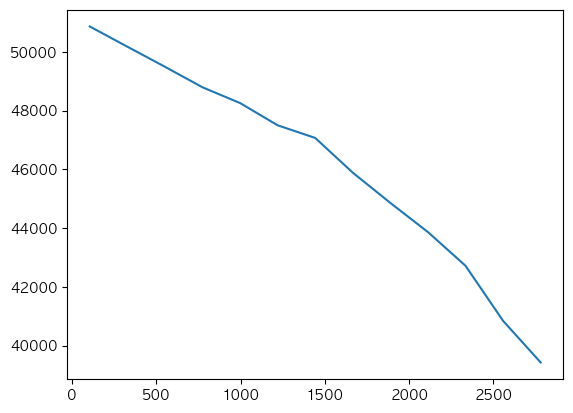

In [27]:
plt.plot(orignal_data, label='Observed Data')